<a href="https://colab.research.google.com/github/davibuss/Homework2-Caltech101/blob/master/Homework2_MLDL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Install requirements**

In [0]:
!pip3 install 'torch==1.3.1'
!pip3 install 'torchvision==0.5.0'
!pip3 install 'Pillow-SIMD'
!pip3 install 'tqdm'
!pip install imutils

  Using cached https://files.pythonhosted.org/packages/88/95/90e8c4c31cfc67248bf944ba42029295b77159982f532c5689bcfe4e9108/torch-1.3.1-cp36-cp36m-manylinux1_x86_64.whl
ERROR: torchvision 0.5.0 has requirement torch==1.4.0, but you'll have torch 1.3.1 which is incompatible.
  Found existing installation: torch 1.4.0
    Uninstalling torch-1.4.0:
      Successfully uninstalled torch-1.4.0


  Using cached https://files.pythonhosted.org/packages/24/19/4804aea17cd136f1705a5e98a00618cb8f6ccc375ad8bfa437408e09d058/torch-1.4.0-cp36-cp36m-manylinux1_x86_64.whl
  Found existing installation: torch 1.3.1
    Uninstalling torch-1.3.1:
      Successfully uninstalled torch-1.3.1


In [2]:
!pip install pretrainedmodels

     |████████████████████████████████| 61kB 1.8MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60962 sha256=8364b0d04a84d178db7ab8d65d7b0a461389865da19069b44a155ab0bc02df44
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built pretrainedmodels


**Import libraries**

In [0]:
import os
import logging
import os.path
import sys
import re
import cv2
import numpy as np
import time

from collections import defaultdict

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader,Dataset
from torch.backends import cudnn
from torchvision.datasets import VisionDataset
from torch.utils.data.sampler import SubsetRandomSampler
import pretrainedmodels
import torch.nn.functional as F

import torchvision
from torchvision import transforms
from torchvision.models import alexnet
from sklearn.model_selection import train_test_split
from PIL import Image
from tqdm import tqdm

**Set Arguments**

In [0]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 102 # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-3            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 5     # Total number of training epochs (iterations over dataset)
#STEP_SIZE = 20      # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

**Define Data Preprocessing**

In [0]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalizes tensor with mean and standard deviation
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                                    
])

**Prepare Dataset**

In [121]:
# Clone github repository with data
if not os.path.isdir('./Caltech101'):
  !git clone https://github.com/davibuss/Homework2-Caltech101.git
  !mv 'Homework2-Caltech101' 'Caltech101'

DATA_DIR = 'Caltech101/101_ObjectCategories'
from Caltech101.caltech_dataset import Caltech


# Prepare Pytorch train/test Datasets
train_dataset = Caltech(DATA_DIR, split='train',  transform=train_transform)
test_dataset = Caltech(DATA_DIR, split='test', transform=eval_transform)
print(type(train_dataset))
 # split to train val

train_len = int(train_dataset.__len__() * 0.5)
val_len = int(train_dataset.__len__() * 0.5)
train_indexes = np.arange(train_dataset.__len__())
print(train_indexes)
train_labels = np.empty(train_dataset.__len__(), dtype=int)


for index in train_indexes:
  train_labels[index] = train_dataset.__getitem__(index)[1]
print(train_labels)  

train_indexes, val_indexes, _, _ = train_test_split(train_indexes, train_labels, test_size=0.5, random_state=42, stratify=train_labels)


"""
validation_split = 0.5
dataset_size = len(train_dataset)
#print(dataset_size)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if 1 :
    np.random.seed(1337)
    np.random.shuffle(indices)
train_indexes, val_indexes = indices[split:], indices[:split]

print(type(train_indexes))
#train_indexes = SubsetRandomSampler(train_indices)
#val_indexes = SubsetRandomSampler(valid_indices)
#train_indexes, val_indexes = 
#print(type(train_indexes))
#print(train_indexes)
"""

val_dataset = Subset(train_dataset, val_indexes)
train_dataset = Subset(train_dataset, train_indexes)

# Check dataset sizes
print('Train Dataset: {}'.format(len(train_dataset)))
print('Valid Dataset: {}'.format(len(val_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))


<class 'Caltech101.caltech_dataset.Caltech'>
[   0    1    2 ... 5781 5782 5783]
[  0   0   0 ... 100 100 100]
Train Dataset: 2892
Valid Dataset: 2892
Test Dataset: 2893


In [0]:
train_classes = np.zeros(101)

for elem in train_dataset:
  train_classes[elem[1]] += 1

val_classes = np.zeros(101)

for elem in val_dataset:
  val_classes[elem[1]] += 1

[ 18. 267.  14.  14.  15.  18.  15.  11.  42.  33.  15.  28.  30.  17.
  14.  41.  16.  20.  20.  36.  16.  23.  25.  23.  17.  17.  19.  22.
  17.  21.  23.  25.  21.  18.  21.  29. 145. 145.  23.  22.  15.  11.
  12.  17.  33.  33.  14.  18.  30.  27.  10.  22.  28.  38.  20.  27.
  66.  26.  13.  22.  15.  14.  29.  11.  26. 266.  18.  12.  13.  15.
  13.  15.  18.  11.  19.  27.  19.  17.  14.  21.  13.  28.  19.  11.
  21.  15.  28.  20.  21.  12.  29.  16.  28.  25.  80.  12.  20.  12.
  18.  13.  20.]


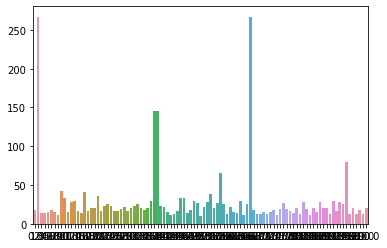

In [123]:
print(train_classes)
ax=sns.barplot(x=np.linspace(0, 100, num=101),y=train_classes)

**Prepare Dataloaders**

In [124]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

print(type(train_dataloader))

<class 'torch.utils.data.dataloader.DataLoader'>


**Prepare Network**

In [0]:
net = alexnet() # Loading AlexNet model

# AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
# We need 101 outputs for Caltech-101
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                 # The convolutional layer is nn.Conv2d

# We just changed the last layer of AlexNet with a new fully connected layer with 101 outputs
# It is strongly suggested to study torchvision.models.alexnet source code

**Prepare Training**

In [0]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

Inserting petrained=True, we have transfer learning from ImageNet.
Inserting petrained=False, we have training from scratch

In [0]:
def validate (model,dataloader):
  print('Validating')
  model = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
  model.train(False) # Set Network to evaluation mode
  
  
  running_corrects = 0
  for epoch in range(NUM_EPOCHS):

    for images, labels in tqdm(dataloader):
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)

  # Forward Pass
      outputs = model(images)
  # Get predictions
      _, preds = torch.max(outputs.data, 1)

  # Update Corrects
      running_corrects += torch.sum(preds == labels.data).data.item()
    

# Calculate Accuracy
    accuracy = running_corrects / float(len(dataloader.dataset))
      
    print('Validation Accuracy: {}'.format(accuracy))

    
    return accuracy

    

In [0]:
# training function
def fit(model, dataloader):
    print('Training')
    model = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
    model.train(True)
    train_running_loss = 0.0
    cudnn.benchmark # Calling this optimizes runtime

    current_step = 0
    
    
  # Iterate over the dataset
    for images, labels in dataloader:
    # Bring data over the device of choice
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)

      model.train() # Sets module in training mode

    # PyTorch, by default, accumulates gradients after each backward pass
    # We need to manually set the gradients to zero before starting a new iteration
      optimizer.zero_grad() # Zero-ing the gradients

    # Forward pass to the network
      outputs = model(images)

    # Compute loss based on output and ground truth
      loss = criterion(outputs, labels)
      
      train_running_loss += loss.item()
      
    # Log loss
      if current_step % LOG_FREQUENCY == 0:
        print('Step {}, Loss {}'.format(current_step, train_running_loss))
        

    # Compute gradients for each layer and update weights
      loss.backward()  # backward pass: computes gradients
      optimizer.step() # update weights based on accumulated gradients

      current_step += 1

      
      
    
      return train_running_loss

  # Step the scheduler
    scheduler.step() 

    


In [212]:

train_loss=[]
val_accuracy=[]

for epoch in range(NUM_EPOCHS):
      print(f"Epoch {epoch+1} of {NUM_EPOCHS}")   
      trainloss=fit(net, train_dataloader)
      valacc=validate(net, val_dataloader)
      train_loss.append(trainloss)
      val_accuracy.append(valacc)

 




Epoch 1 of 5
Training
Step 0, Loss 4.587829113006592


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


100%|██████████| 12/12 [00:13<00:00,  1.09s/it]

Validation Accuracy: 0.165283540802213
Epoch 2 of 5
Training


Step 0, Loss 4.593045234680176


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


100%|██████████| 12/12 [00:13<00:00,  1.09s/it]

Validation Accuracy: 0.16597510373443983
Epoch 3 of 5
Training


Step 0, Loss 4.590283393859863


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


100%|██████████| 12/12 [00:13<00:00,  1.09s/it]

Validation Accuracy: 0.165283540802213
Epoch 4 of 5
Training


Step 0, Loss 4.5863471031188965


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


100%|██████████| 12/12 [00:13<00:00,  1.08s/it]

Validation Accuracy: 0.16459197786998617
Epoch 5 of 5
Training


Step 0, Loss 4.586927890777588


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


100%|██████████| 12/12 [00:12<00:00,  1.08s/it]

Validation Accuracy: 0.1656293222683264


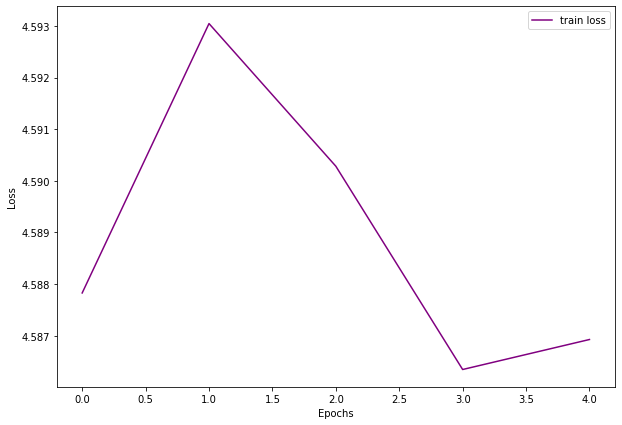

In [213]:
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='purple', label='train loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


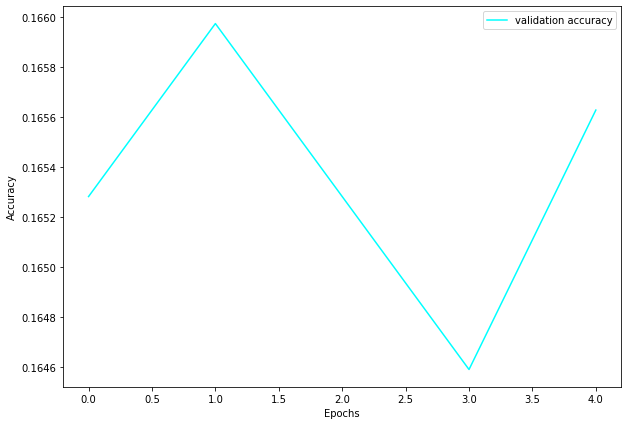

In [214]:
plt.figure(figsize=(10, 7))
plt.plot(val_accuracy, color='cyan', label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [0]:
"""
# By default, everything is loaded to cpu
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

cudnn.benchmark # Calling this optimizes runtime

current_step = 0
# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
  print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))

  # Iterate over the dataset
  for images, labels in train_dataloader:
    # Bring data over the device of choice
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    net.train() # Sets module in training mode

    # PyTorch, by default, accumulates gradients after each backward pass
    # We need to manually set the gradients to zero before starting a new iteration
    optimizer.zero_grad() # Zero-ing the gradients

    # Forward pass to the network
    outputs = net(images)

    # Compute loss based on output and ground truth
    loss = criterion(outputs, labels)

    # Log loss
    if current_step % LOG_FREQUENCY == 0:
      print('Step {}, Loss {}'.format(current_step, loss.item()))

    # Compute gradients for each layer and update weights
    loss.backward()  # backward pass: computes gradients
    optimizer.step() # update weights based on accumulated gradients

    current_step += 1

  # Step the scheduler
  scheduler.step() 
  """

In [0]:
def test (model,dataloader):
  print('Testing')
  model = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
  model.train(False) # Set Network to evaluation mode
  
  
  running_corrects = 0
  for epoch in range(NUM_EPOCHS):

    for images, labels in tqdm(dataloader):
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)

  # Forward Pass
      outputs = net(images)
  # Get predictions
      _, preds = torch.max(outputs.data, 1)

  # Update Corrects
      running_corrects += torch.sum(preds == labels.data).data.item()
    

# Calculate Accuracy
    accuracy = running_corrects / float(len(dataloader.dataset))
      
    print('Testing Accuracy: {}'.format(accuracy))

    
    return accuracy


In [221]:
train_loss=[]
test_accuracy=[]

for epoch in range(NUM_EPOCHS):
      print(f"Epoch {epoch+1} of {NUM_EPOCHS}")   
      trainloss=fit(net, train_dataloader)
      testacc=test(net, test_dataloader)
      train_loss.append(trainloss)
      test_accuracy.append(testacc)


Epoch 1 of 5
Training
Step 0, Loss 4.58450174331665


  0%|          | 0/12 [00:00<?, ?it/s]

Testing


100%|██████████| 12/12 [00:13<00:00,  1.09s/it]

Testing Accuracy: 0.16038714137573454
Epoch 2 of 5
Training


Step 0, Loss 4.585124492645264


  0%|          | 0/12 [00:00<?, ?it/s]

Testing


100%|██████████| 12/12 [00:13<00:00,  1.08s/it]

Testing Accuracy: 0.15865883166263395
Epoch 3 of 5
Training


Step 0, Loss 4.582199573516846


  0%|          | 0/12 [00:00<?, ?it/s]

Testing


100%|██████████| 12/12 [00:13<00:00,  1.08s/it]

Testing Accuracy: 0.1579675077773937
Epoch 4 of 5
Training


Step 0, Loss 4.583999156951904


  0%|          | 0/12 [00:00<?, ?it/s]

Testing


100%|██████████| 12/12 [00:13<00:00,  1.09s/it]

Testing Accuracy: 0.15727618389215348
Epoch 5 of 5
Training


Step 0, Loss 4.5872931480407715


  0%|          | 0/12 [00:00<?, ?it/s]

Testing


100%|██████████| 12/12 [00:13<00:00,  1.09s/it]

Testing Accuracy: 0.1555478741790529


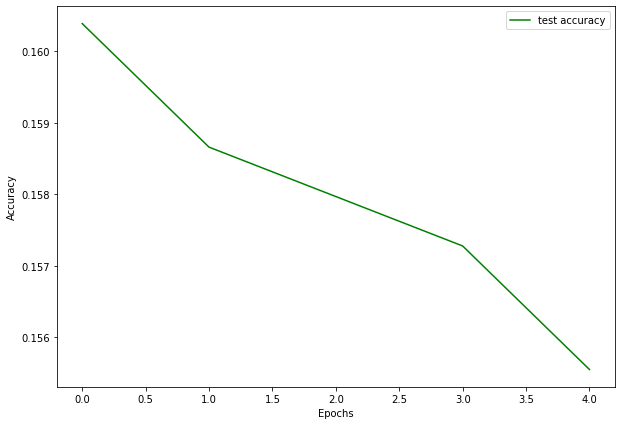

In [224]:
plt.figure(figsize=(10, 7))
plt.plot(test_accuracy, color='green', label='test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**Train**

In [201]:
"""
# By default, everything is loaded to cpu
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

cudnn.benchmark # Calling this optimizes runtime

current_step = 0
# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
  print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))

  # Iterate over the dataset
  for images, labels in train_dataloader:
    # Bring data over the device of choice
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    net.train() # Sets module in training mode

    # PyTorch, by default, accumulates gradients after each backward pass
    # We need to manually set the gradients to zero before starting a new iteration
    optimizer.zero_grad() # Zero-ing the gradients

    # Forward pass to the network
    outputs = net(images)

    # Compute loss based on output and ground truth
    loss = criterion(outputs, labels)

    # Log loss
    if current_step % LOG_FREQUENCY == 0:
      print('Step {}, Loss {}'.format(current_step, loss.item()))

    # Compute gradients for each layer and update weights
    loss.backward()  # backward pass: computes gradients
    optimizer.step() # update weights based on accumulated gradients

    current_step += 1

  # Step the scheduler
  scheduler.step() 
  """

"\n# By default, everything is loaded to cpu\nnet = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda\n\ncudnn.benchmark # Calling this optimizes runtime\n\ncurrent_step = 0\n# Start iterating over the epochs\nfor epoch in range(NUM_EPOCHS):\n  print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))\n\n  # Iterate over the dataset\n  for images, labels in train_dataloader:\n    # Bring data over the device of choice\n    images = images.to(DEVICE)\n    labels = labels.to(DEVICE)\n\n    net.train() # Sets module in training mode\n\n    # PyTorch, by default, accumulates gradients after each backward pass\n    # We need to manually set the gradients to zero before starting a new iteration\n    optimizer.zero_grad() # Zero-ing the gradients\n\n    # Forward pass to the network\n    outputs = net(images)\n\n    # Compute loss based on output and ground truth\n    loss = criterion(outputs, labels)\n\n    # Log loss\n    if current_step % LO

**Validation**

In [202]:
"""
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(val_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(val_dataset))

print('Validation Accuracy: {}'.format(accuracy))
"""

"\nnet = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda\nnet.train(False) # Set Network to evaluation mode\n\nrunning_corrects = 0\nfor images, labels in tqdm(val_dataloader):\n  images = images.to(DEVICE)\n  labels = labels.to(DEVICE)\n\n  # Forward Pass\n  outputs = net(images)\n\n  # Get predictions\n  _, preds = torch.max(outputs.data, 1)\n\n  # Update Corrects\n  running_corrects += torch.sum(preds == labels.data).data.item()\n\n# Calculate Accuracy\naccuracy = running_corrects / float(len(val_dataset))\n\nprint('Validation Accuracy: {}'.format(accuracy))\n"

**Test**

In [223]:
"""
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(test_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(test_dataset))

print('Test Accuracy: {}'.format(accuracy))
"""

"\nnet = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda\nnet.train(False) # Set Network to evaluation mode\n\nrunning_corrects = 0\nfor images, labels in tqdm(test_dataloader):\n  images = images.to(DEVICE)\n  labels = labels.to(DEVICE)\n\n  # Forward Pass\n  outputs = net(images)\n\n  # Get predictions\n  _, preds = torch.max(outputs.data, 1)\n\n  # Update Corrects\n  running_corrects += torch.sum(preds == labels.data).data.item()\n\n# Calculate Accuracy\naccuracy = running_corrects / float(len(test_dataset))\n\nprint('Test Accuracy: {}'.format(accuracy))\n"